# **SC Distribution Plots**

Estadísticas guardadas en: plots/sc_stats_ctrl_schz.txt


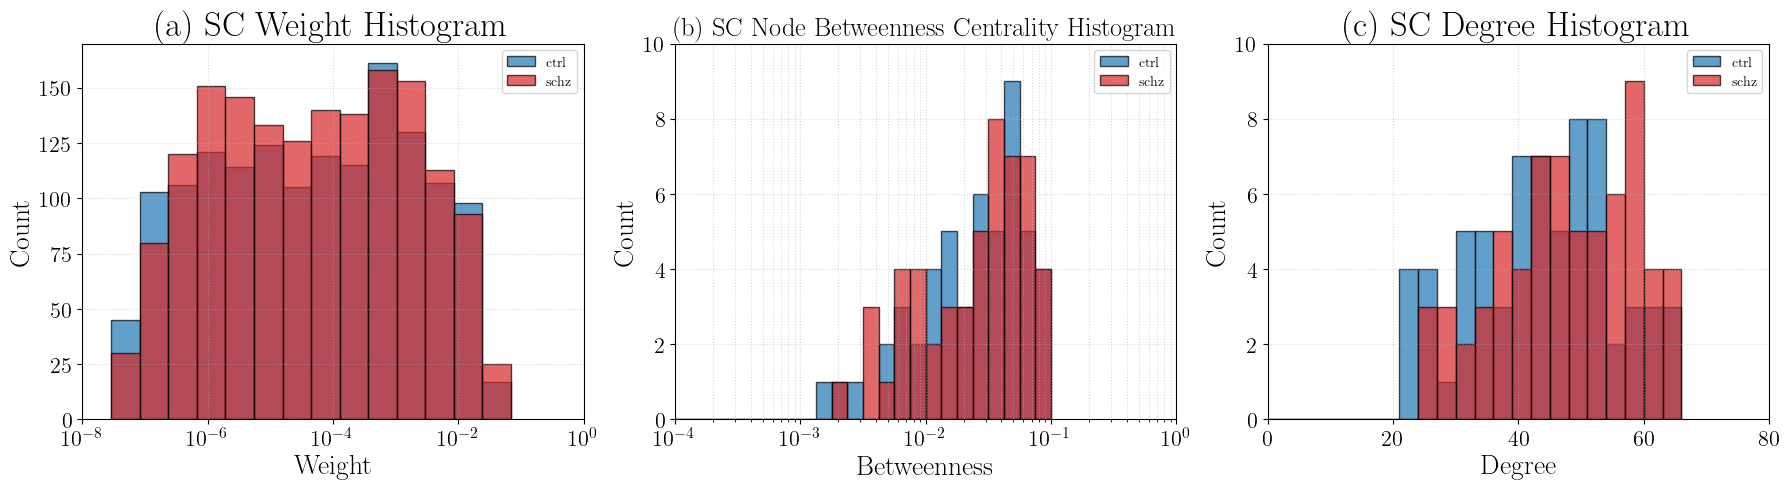

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from pathlib import Path

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def plot_sc_distributions(
    emp_base,
    file_ctrl = "avg_sc_ctrl_1.csv",
    file_schz = "avg_sc_schz_1.csv",
    bins_weight=50,
    bins_betweenness=40,
    bins_degree=30,
    save_name="network_distributions_SC_CTRL_SCHZ_scale_1.png",
    stats_file="sc_stats_ctrl_schz.txt",
    xlims=None,
    ylims=None
):
    Path(save_name).parent.mkdir(parents=True, exist_ok=True)
    Path(stats_file).parent.mkdir(parents=True, exist_ok=True)

    # --- Grupos
    groups = {
        "ctrl": {"file": file_ctrl, "color": "#1f77b4"},
        "schz": {"file": file_schz, "color": "#d62728"}
    }

    # --- Cargar y procesar datos
    network_data = {}
    for group, conf in groups.items():
        path = os.path.join(emp_base, conf["file"])
        sc = np.genfromtxt(path, delimiter=",")

        G = nx.from_numpy_array(sc)
        weights = [data["weight"] for _, _, data in G.edges(data=True)]
        inv_weights = {
            (u, v): 1 / abs(w) if w != 0 else 0
            for u, v, w in G.edges(data="weight")
        }
        nx.set_edge_attributes(G, inv_weights, name="inv_weight")

        betweenness = list(nx.betweenness_centrality(G, weight="inv_weight").values())
        degrees = [deg for _, deg in G.degree()]

        network_data[group] = {
            "weight": np.array(weights),
            "betweenness": np.array(betweenness),
            "degree": np.array(degrees)
        }

    # --- Guardar estadísticas
    with open(stats_file, "w") as f:
        for group in groups:
            f.write(f"\n--- {group} ---\n")
            for key in ["weight", "betweenness", "degree"]:
                data = network_data[group][key]
                data = data[np.isfinite(data) & (data > 0 if key == "betweenness" else True)]
                mean = np.mean(data)
                std = np.std(data)
                f.write(f"{key.capitalize():<12} -> Mean = {mean:.4f}, Std = {std:.4f}\n")
    print(f"Estadísticas guardadas en: {stats_file}")

    # --- Bins
    all_weights = np.concatenate([network_data["ctrl"]["weight"], network_data["schz"]["weight"]])
    min_weight = min(w for w in all_weights if w > 0)
    max_weight = max(all_weights)
    bins_weight_edges = np.logspace(np.log10(min_weight), np.log10(max_weight), bins_weight)

    bins_betweenness_edges = np.logspace(-4, -1, bins_betweenness)
    max_deg = max([max(network_data[g]["degree"]) for g in groups])
    bins_degree_edges = np.arange(0, max_deg + 1, max(1, max_deg // bins_degree))

    # --- Plot
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Peso
    ax = axs[0]
    for group in groups:
        ax.hist(network_data[group]["weight"], bins=bins_weight_edges, alpha=0.7,
                label=group, color=groups[group]["color"], edgecolor='black')
    ax.set_title("(a) SC Weight Histogram", fontsize=25)
    ax.set_xlabel("Weight", fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    ax.set_xscale("log")
    ax.tick_params(axis='both', which='major', labelsize=16)
    if xlims and "weight" in xlims: ax.set_xlim(xlims["weight"])
    if ylims and "weight" in ylims: ax.set_ylim(ylims["weight"])
    ax.grid(True, linestyle=":", alpha=0.5, which='both')
    ax.legend()

    # Betweenness
    ax = axs[1]
    for group in groups:
        ax.hist(network_data[group]["betweenness"], bins=bins_betweenness_edges, alpha=0.7,
                label=group, color=groups[group]["color"], edgecolor='black')
    ax.set_title("(b) SC Node Betweenness Centrality Histogram", fontsize=19)
    ax.set_xlabel("Betweenness", fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    ax.set_xscale("log")
    ax.tick_params(axis='both', which='major', labelsize=16)
    if xlims and "betweenness" in xlims: ax.set_xlim(xlims["betweenness"])
    if ylims and "betweenness" in ylims: ax.set_ylim(ylims["betweenness"])
    ax.grid(True, linestyle=":", alpha=0.5, which='both')
    ax.legend()

    # Degree
    ax = axs[2]
    for group in groups:
        ax.hist(network_data[group]["degree"], bins=bins_degree_edges, alpha=0.7,
                label=group, color=groups[group]["color"], edgecolor='black')
    ax.set_title("(c) SC Degree Histogram", fontsize=25)
    ax.set_xlabel("Degree", fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    if xlims and "degree" in xlims: ax.set_xlim(xlims["degree"])
    if ylims and "degree" in ylims: ax.set_ylim(ylims["degree"])
    ax.grid(True, linestyle=":", alpha=0.5)
    ax.legend()

    plt.tight_layout()
    plt.savefig(save_name, dpi=300)
    plt.show()


plot_sc_distributions(
    emp_base=f"data/avg_conn_matrices_no_subcortical",
    bins_weight=15,
    bins_betweenness=25,
    bins_degree=20,
    save_name="plots/network_distributions_sc_ctrl_schz_scale_1.png",
    stats_file="plots/sc_stats_ctrl_schz.txt",
    xlims={
        "weight": (1e-8, 1e0),
        "betweenness": (1e-4, 1e0),
        "degree": (0, 80)
    },
    ylims={
        "weight": (0, 170),
        "betweenness": (0, 10),
        "degree": (0, 10)
    }
)



# **Correlation and Distance --- Global**

> **Note:** The correlation and distance plots shown here were generated from results produced with an earlier version of the simulation scripts.  
> As a consequence, the data loading section of this plot differs slightly from the current file structure in the repository.  
> If you run new simulations using the updated code, you will only need to adjust the file loading step in this plotting routine. The results remain directly comparable.

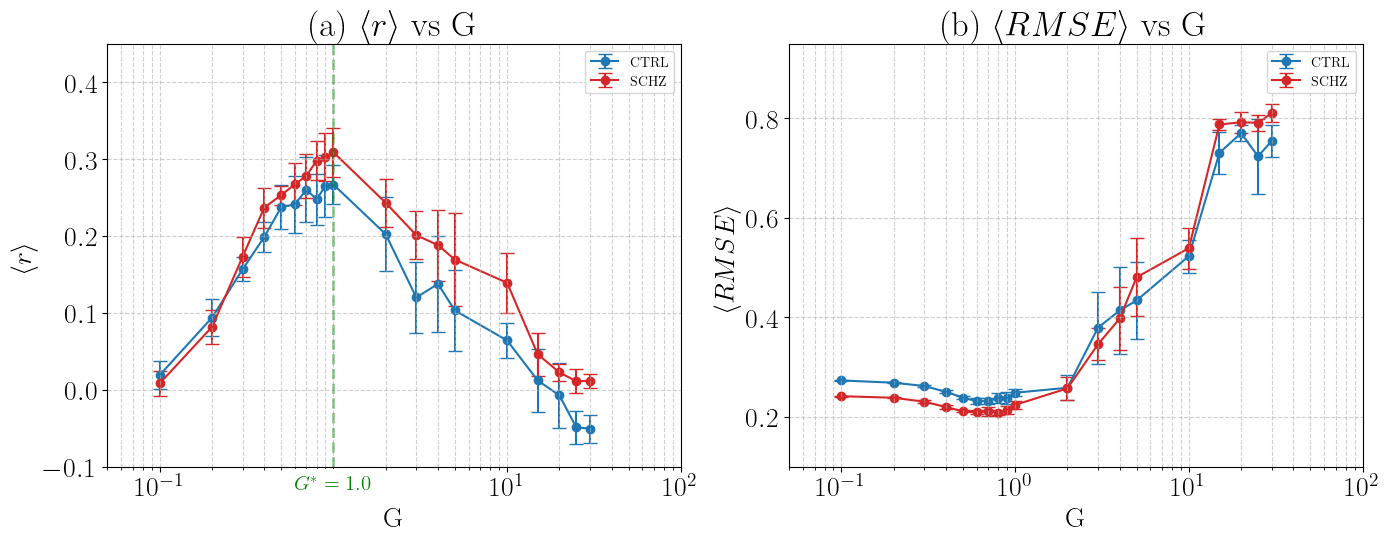

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

@njit
def calc_corr_rmse(A, B):
    n = A.shape[0]
    size = (n * (n - 1)) // 2
    v1 = np.empty(size)
    v2 = np.empty(size)
    idx = 0
    for i in range(n):
        for j in range(i):
            v1[idx] = A[i, j]
            v2[idx] = B[i, j]
            idx += 1
    m1 = np.mean(v1)
    m2 = np.mean(v2)
    cov = np.sum((v1 - m1) * (v2 - m2))
    var1 = np.sum((v1 - m1)**2)
    var2 = np.sum((v2 - m2)**2)
    corr = cov / np.sqrt(var1 * var2)
    rmse = np.sqrt(np.mean((v1 - v2)**2))
    return corr, rmse

# === Parameters ===
G_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0]
sims = list(range(1, 11))
scale = 1

# === Axis scale and limits ===
xscale_corr = "log"
yscale_corr = "linear"
xlim_corr = (0.05, 100)
ylim_corr = (-0.1, 0.45)

xscale_rmse = "log"
yscale_rmse = "linear"
xlim_rmse = (0.05, 100)
ylim_rmse = (0.1, 0.95)

# === Paths ===
root_dir = f"results_article/results_global"
emp_base = f"data/avg_conn_matrices_no_subcortical"

# === Plot setup
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

colors = {"ctrl": "#1f77b4", "schz": "#d62728"}
mean_corrs_all = {}
G_star_dict = {}

for group in ["ctrl", "schz"]:
    emp_file = os.path.join(emp_base, f"AVG_FC_{group.upper()}_{scale}.csv")
    FC_emp = np.genfromtxt(emp_file, delimiter=",")

    mean_corrs = []
    std_corrs = []
    mean_rmses = []
    std_rmses = []

    for G in G_vals:
        corrs, rmses = [], []

        for sim in sims:
            sim_file = os.path.join(root_dir, f"{group}", f"sim_{sim}", f"FC_G_{G:.2f}.txt")

            if os.path.exists(sim_file):
                FC_sim = np.genfromtxt(sim_file, delimiter=",")
                corr, rmse = calc_corr_rmse(FC_sim, FC_emp)
                corrs.append(corr)
                rmses.append(rmse)

        if corrs:
            mean_corrs.append(np.mean(corrs))
            std_corrs.append(np.std(corrs))
            mean_rmses.append(np.mean(rmses))
            std_rmses.append(np.std(rmses))
        else:
            mean_corrs.append(np.nan)
            std_corrs.append(np.nan)
            mean_rmses.append(np.nan)
            std_rmses.append(np.nan)

    mean_corrs = np.array(mean_corrs)
    std_corrs = np.array(std_corrs)
    mean_rmses = np.array(mean_rmses)
    std_rmses = np.array(std_rmses)

    mean_corrs_all[group] = mean_corrs

    axs[0].errorbar(G_vals, mean_corrs, yerr=std_corrs, fmt='-o', capsize=5,
                    label=group.upper(), color=colors[group], zorder=1)
    axs[1].errorbar(G_vals, mean_rmses, yerr=std_rmses, fmt='-o', capsize=5,
                    label=group.upper(), color=colors[group], zorder=1)

    # === Store G* for each group
    G_array = np.array(G_vals)
    valid_idx = G_array <= 1.0
    best_idx = np.nanargmax(mean_corrs[valid_idx])
    G_star_dict[group] = G_array[valid_idx][best_idx]

# === If both groups have the same G*, mark once
if np.isclose(G_star_dict["ctrl"], G_star_dict["schz"]):
    G_star = G_star_dict["ctrl"]
    axs[0].axvline(x=G_star, color="green", linestyle="--", linewidth=2, alpha=0.4, zorder=20)
    axs[0].text(
        G_star, ylim_corr[0] - 0.01,
        f"$G^* = {G_star:.1f}$",
        ha='center', va='top',
        fontsize=15,
        color="green",
        backgroundcolor='white',
        zorder=20
    )

# === Styling
axs[0].set_xlabel("G", fontsize=20)
axs[0].set_ylabel(rf"$\langle r \rangle$", fontsize=20)
axs[0].set_title(rf"(a) $\langle r \rangle$ vs G", fontsize=25)
axs[0].set_xscale(xscale_corr)
axs[0].set_yscale(yscale_corr)
axs[0].set_xlim(xlim_corr)
axs[0].set_ylim(ylim_corr)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].grid(True, which="both", ls="--", alpha=0.6)
axs[0].legend()

axs[1].set_xlabel("G", fontsize=20)
axs[1].set_ylabel(rf"$\langle RMSE \rangle$", fontsize=20)
axs[1].set_title(rf"(b) $\langle RMSE \rangle$ vs G", fontsize=25)
axs[1].set_xscale(xscale_rmse)
axs[1].set_yscale(yscale_rmse)
axs[1].set_xlim(xlim_rmse)
axs[1].set_ylim(ylim_rmse)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].grid(True, which="both", ls="--", alpha=0.6)
axs[1].legend()

#plt.suptitle(f"Average FC Comparison Metrics – Scale {scale}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("plots/corr_dist_global.png", dpi=300)
plt.show()

# **Correlation and Distance --- Hemispheric**

> **Note:** The correlation and distance plots shown here were generated from results produced with an earlier version of the simulation scripts.  
> As a consequence, the data loading section of this plot differs slightly from the current file structure in the repository.  
> If you run new simulations using the updated code, you will only need to adjust the file loading step in this plotting routine. The results remain directly comparable.

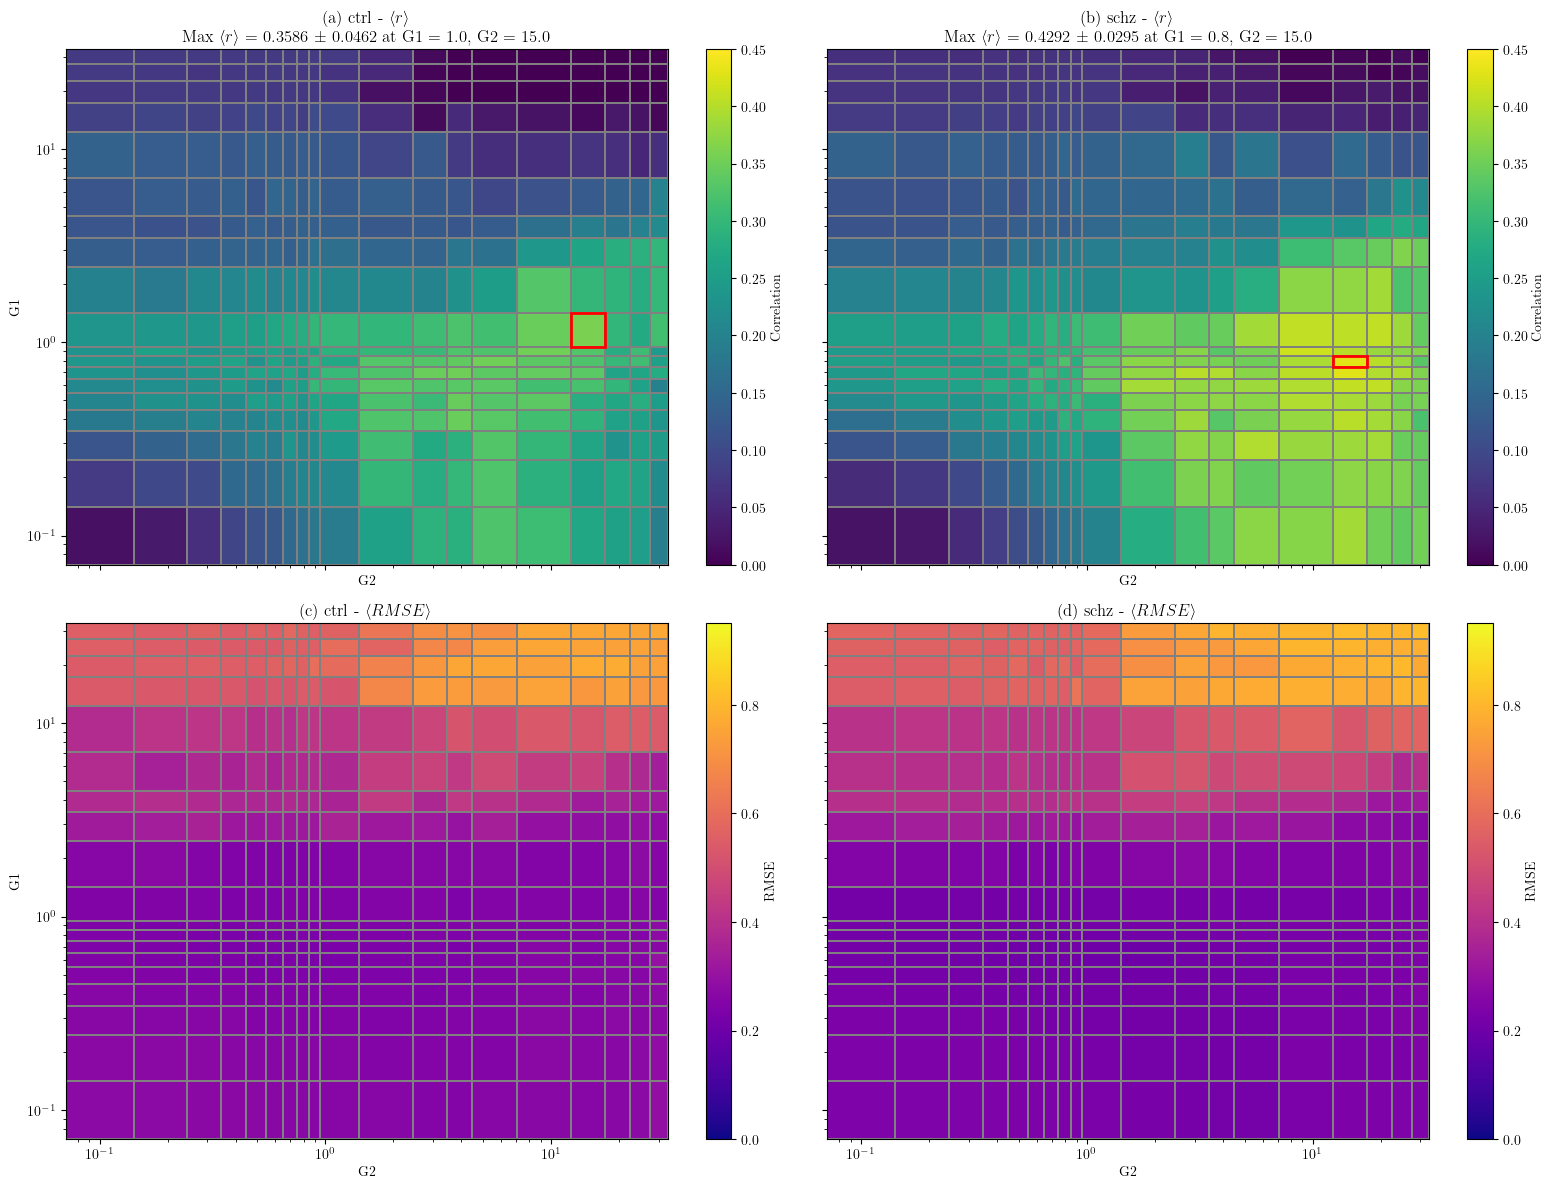

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# === Ruta de los archivos
archivo_ctrl = f"results_article/results_hemispheric/ctrl/corr_dist_results.txt"
archivo_schz = f"results_article/results_hemispheric/schz/corr_dist_results.txt"

# === Límites de colorbar (ajustables)
vmin_corr = 0.0
vmax_corr = 0.45
vmin_rmse = 0.0
vmax_rmse = 0.95

# === Valores de G reales
G_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
          2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0]

def compute_edges(vals):
    edges = [vals[0] / np.sqrt(vals[1] / vals[0])]
    for i in range(len(vals) - 1):
        edges.append(np.sqrt(vals[i] * vals[i + 1]))
    edges.append(vals[-1] * np.sqrt(vals[-1] / vals[-2]))
    return np.array(edges)

G_edges = compute_edges(G_vals)

def process_file(archivo, group_label):
    df = pd.read_csv(archivo)
    pivot_corr = df.pivot_table(values="correlation", index="G1", columns="G2", aggfunc="mean").reindex(index=G_vals, columns=G_vals)
    pivot_std  = df.pivot_table(values="correlation", index="G1", columns="G2", aggfunc="std").reindex(index=G_vals, columns=G_vals)
    pivot_rmse = df.pivot_table(values="distance", index="G1", columns="G2", aggfunc="mean").reindex(index=G_vals, columns=G_vals)
    
    Z_corr = pivot_corr.values
    Z_std  = pivot_std.values
    Z_rmse = pivot_rmse.values

    max_idx = np.unravel_index(np.nanargmax(Z_corr), Z_corr.shape)
    best_G1 = G_vals[max_idx[0]]
    best_G2 = G_vals[max_idx[1]]
    max_corr = Z_corr[max_idx]
    std_corr = Z_std[max_idx]
    rmse_at_max = Z_rmse[max_idx]

    return {
        "label": group_label,
        "Z_corr": Z_corr,
        "Z_std": Z_std,
        "Z_rmse": Z_rmse,
        "max_idx": max_idx,
        "max_corr": max_corr,
        "std_corr": std_corr,
        "rmse_at_max": rmse_at_max,
        "best_G1": best_G1,
        "best_G2": best_G2
    }

# === Procesar datos
data_ctrl = process_file(archivo_ctrl, "CTRL")
data_schz = process_file(archivo_schz, "SCHZ")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# === Crear figura
fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
datasets = [data_ctrl, data_schz]
labels = [["(a)", "(c)"], ["(b)", "(d)"]]
cmaps = [["viridis", "plasma"], ["viridis", "plasma"]]
vmins = [[vmin_corr, vmin_rmse], [vmin_corr, vmin_rmse]]
vmaxs = [[vmax_corr, vmax_rmse], [vmax_corr, vmax_rmse]]

for i, data in enumerate(datasets):
    for j, metric in enumerate(["Z_corr", "Z_rmse"]):
        Z = data[metric]
        ax = axs[j][i]
        pcm = ax.pcolormesh(
            G_edges, G_edges, Z, shading="auto",
            cmap=cmaps[i][j],
            vmin=vmins[i][j], vmax=vmaxs[i][j],
            edgecolors='gray', linewidth=0.3
        )
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("G2")
        if i == 0:
            ax.set_ylabel("G1")

        # Construir título
        if metric == "Z_corr":
            title = (
                f"{labels[i][j]} {data['label']} - $\\langle r \\rangle$\n"
                f"Max $\\langle r \\rangle$ = {data['max_corr']:.4f} ± {data['std_corr']:.4f} at G1 = {data['best_G1']}, G2 = {data['best_G2']}"
            )
        else:
            title = f"{labels[i][j]} {data['label']} - $\\langle RMSE \\rangle$"

        ax.set_title(title)
        fig.colorbar(pcm, ax=ax, label="Correlation" if metric == "Z_corr" else "RMSE")

        # Cuadro rojo en el máximo de correlación
        if metric == "Z_corr":
            row, col = data["max_idx"]
            x0 = G_edges[col]
            y0 = G_edges[row]
            width = G_edges[col + 1] - x0
            height = G_edges[row + 1] - y0
            rect = plt.Rectangle((x0, y0), width, height, linewidth=2,
                                 edgecolor='red', facecolor='none')
            ax.add_patch(rect)

plt.tight_layout()
plt.savefig("plots/corr_dist_hemispheric.png", dpi=300)
plt.show()

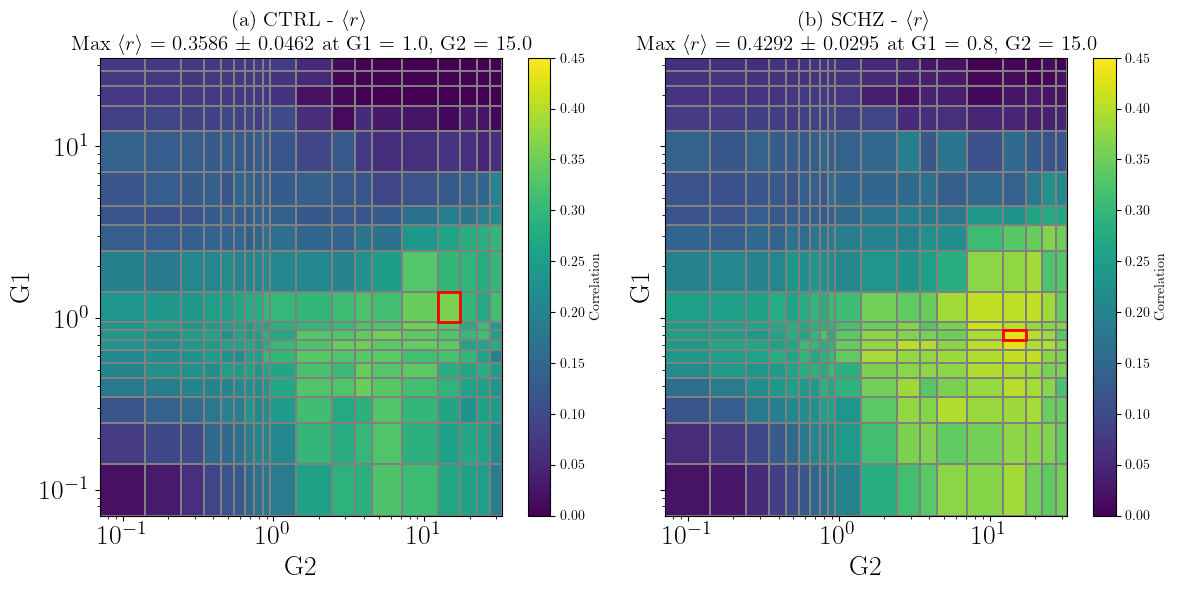

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === Archivos de entrada
archivo_ctrl = f"results_article/results_hemispheric/ctrl/corr_dist_results.txt"
archivo_schz = f"results_article/results_hemispheric/schz/corr_dist_results.txt"

# === Límites para colorbar
vmin_corr = 0.0
vmax_corr = 0.45

# === Valores de G reales
G_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
          2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0]

def compute_edges(vals):
    edges = [vals[0] / np.sqrt(vals[1] / vals[0])]
    for i in range(len(vals) - 1):
        edges.append(np.sqrt(vals[i] * vals[i + 1]))
    edges.append(vals[-1] * np.sqrt(vals[-1] / vals[-2]))
    return np.array(edges)

G_edges = compute_edges(G_vals)

def process_file(archivo, group_label):
    df = pd.read_csv(archivo)
    pivot_corr = df.pivot_table(values="correlation", index="G1", columns="G2", aggfunc="mean").reindex(index=G_vals, columns=G_vals)
    pivot_std  = df.pivot_table(values="correlation", index="G1", columns="G2", aggfunc="std").reindex(index=G_vals, columns=G_vals)
    
    Z_corr = pivot_corr.values
    Z_std  = pivot_std.values

    max_idx = np.unravel_index(np.nanargmax(Z_corr), Z_corr.shape)
    best_G1 = G_vals[max_idx[0]]
    best_G2 = G_vals[max_idx[1]]
    max_corr = Z_corr[max_idx]
    std_corr = Z_std[max_idx]

    return {
        "label": group_label,
        "Z_corr": Z_corr,
        "Z_std": Z_std,
        "max_idx": max_idx,
        "max_corr": max_corr,
        "std_corr": std_corr,
        "best_G1": best_G1,
        "best_G2": best_G2
    }

# === Procesar datos
data_ctrl = process_file(archivo_ctrl, "CTRL")
data_schz = process_file(archivo_schz, "SCHZ")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# === Crear figura 1×2 solo con correlaciones
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

for ax, data, label in zip(axs, [data_ctrl, data_schz], ["(a)", "(b)"]):
    Z = data["Z_corr"]
    pcm = ax.pcolormesh(
        G_edges, G_edges, Z, shading="auto",
        cmap="viridis", vmin=vmin_corr, vmax=vmax_corr,
        edgecolors='gray', linewidth=0.3
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("G2", fontsize=20)
    ax.set_ylabel("G1", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    title = (
        f"{label} {data['label']} - $\\langle r \\rangle$\n"
        f"Max $\\langle r \\rangle$ = {data['max_corr']:.4f} $\pm$ {data['std_corr']:.4f} "
        f"at G1 = {data['best_G1']}, G2 = {data['best_G2']}"
    )
    ax.set_title(title, fontsize=15)
    fig.colorbar(pcm, ax=ax, label="Correlation")

    # Cuadro rojo en el máximo
    row, col = data["max_idx"]
    x0 = G_edges[col]
    y0 = G_edges[row]
    width = G_edges[col + 1] - x0
    height = G_edges[row + 1] - y0
    rect = plt.Rectangle((x0, y0), width, height, linewidth=2,
                         edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.tight_layout()
plt.savefig("plots/corr_hemispheric.png", dpi=300)
plt.show()